<a href="https://colab.research.google.com/github/88pawankumarjha/ExtSimpleExamples/blob/master/TF2_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yahoo_fin

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [ ]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [ ]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # take last 700 days 
    df = df.tail(700)
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
 
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [ ]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [ ]:
# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 6
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 2000
# Cipla stock market
ticker = "CIPLA.NS"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [ ]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [ ]:
import time
from datetime import datetime
import pytz
 
# starting time
start = time.time()
tz_India = pytz.timezone('Asia/Kolkata')
datetime_India = datetime.now(tz_India)
print("Starting time:", datetime_India.strftime("%H:%M:%S"))

Starting time: 15:33:17


In [ ]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)


In [ ]:
data["df"].tail()

,open,high,low,close,adjclose,volume,ticker
2020-07-28,651.000000,665.750000,644.250000,662.599976,662.599976,4583066.0,CIPLA.NS
2020-07-29,662.599976,685.549988,662.599976,681.250000,681.250000,7288781.0,CIPLA.NS
2020-07-30,681.200012,698.950012,681.000000,685.950012,685.950012,7170665.0,CIPLA.NS
2020-07-31,687.000000,724.000000,687.000000,720.150024,720.150024,18897302.0,CIPLA.NS
2020-08-03,724.000000,734.200012,701.000000,711.150024,711.150024,12498515.0,CIPLA.NS


In [ ]:
 # construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
 
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
 
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
 
model.save(os.path.join("results", model_name) + ".h5")

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - ETA: 0s - loss: 4.0735e-04 - mean_absolute_error: 0.0226
Epoch 00751: val_loss did not improve from 0.00038
8/8 [==============================] - 1s 186ms/step - loss: 4.0735e-04 - mean_absolute_error: 0.0226 - val_loss: 4.0852e-04 - val_mean_absolute_error: 0.0223
Epoch 752/2000
8/8 [==============================] - ETA: 0s - loss: 4.4818e-04 - mean_absolute_error: 0.0232
Epoch 00752: val_loss did not improve from 0.00038
8/8 [==============================] - 2s 203ms/step - loss: 4.4818e-04 - mean_absolute_error: 0.0232 - val_loss: 4.3496e-04 - val_mean_absolute_error: 0.0236
Epoch 753/2000
8/8 [==============================] - ETA: 0s - loss: 3.9109e-04 - mean_absolute_error: 0.0224
Epoch 00753: val_loss did not improve from 0.00038
8/8 [==============================] - 2s 204ms/step - loss: 3.9109e-04 - mean_absolute_error: 0.0224 - val_loss: 4.2106e-04 - val_mean_absolute_error: 0.0231
E

In [ ]:
 
 
# end time
end = time.time()

Runtime of the program is 63.16096084912618 minutes


In [ ]:
# tensorboard --logdir="logs"

In [ ]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
 
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
 
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [ ]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]

Mean Absolute Error: 379.5867819116131


In [ ]:
def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [ ]:
# predict the future price
future_price = predict(model, data)

In [ ]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-5:], c='b')
    plt.plot(y_pred[-5:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    plt.plot(y_test[-30:], c='b')
    plt.plot(y_pred[-30:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    
    # returning deviation of past 3 days  
    print("validate past deviations : yesterday -- ", (y_pred[-1] - y_test[-1] ) , (y_pred[-2] - y_test[-2] ) , (y_pred[-3] - y_test[-3]) , (y_pred[-4] - y_test[-4]) , (y_pred[-5] - y_test[-5]) )
    return ((y_pred[-1] - y_test[-1]) + (y_pred[-2] - y_test[-2])+ (y_pred[-3] - y_test[-3])+ (y_pred[-4] - y_test[-4])+(y_pred[-5] - y_test[-5]))/5

In [ ]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [ ]:
def get_confusionmatrix(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return confusion_matrix(y_test, y_pred)

In [ ]:
def get_classification_report(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return classification_report(y_test, y_pred)

In [ ]:
data["df"].tail()

,open,high,low,close,adjclose,volume,ticker
2020-07-28,651.000000,665.750000,644.250000,662.599976,662.599976,4583066.0,CIPLA.NS
2020-07-29,662.599976,685.549988,662.599976,681.250000,681.250000,7288781.0,CIPLA.NS
2020-07-30,681.200012,698.950012,681.000000,685.950012,685.950012,7170665.0,CIPLA.NS
2020-07-31,687.000000,724.000000,687.000000,720.150024,720.150024,18897302.0,CIPLA.NS
2020-08-03,724.000000,734.200012,701.000000,710.400024,710.400024,12498511.0,CIPLA.NS


Possible future price
Possible future price


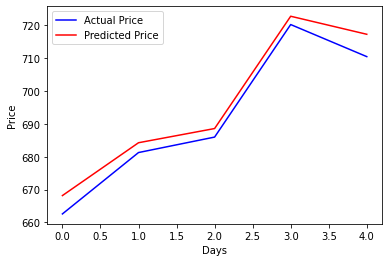

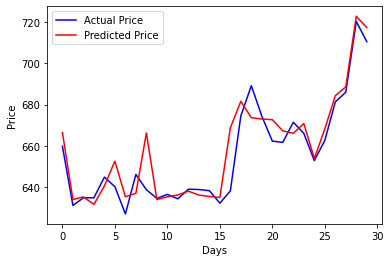

validate past deviations : yesterday --  6.793212890624886 2.52392578125 2.59625244140625 2.98333740234375 5.57623291015625
Possible future price:  705.1565063476563
Possible future price
Possible future price


In [ ]:
print("Possible future price")
print("Possible future price")
print("Possible future price: ", future_price - plot_graph(model, data) )
print("Possible future price")
print("Possible future price")

In [ ]:
print("Future price after", LOOKUP_STEP,  " days is ", future_price, " Rs")
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))
print("Mean Absolute Error:", mean_absolute_error )

Future price after 1  days is  709.2511  Rs
1: Accuracy Score: 0.8823529411764706
Mean Absolute Error: 379.5867819116131


In [ ]:
# need high f1 score
print("Confusion matrix:", get_confusionmatrix(model, data))
print (get_classification_report(model, data))

Confusion matrix: [[53 10]
 [ 4 52]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        63
           1       0.84      0.93      0.88        56

    accuracy                           0.88       119
   macro avg       0.88      0.88      0.88       119
weighted avg       0.89      0.88      0.88       119



In [ ]:
# https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras
# n_steps 5, 10 --> 1: Accuracy Score: 0.6956521739130435, Future price after 1 days is 664.44 Rs
# n_steps 50, 100, n_layers=2,3, EPOCHS = 400 --> 1: Accuracy Score: 0.7142857142857143, Future price after 1 days is 663.50 Rs
# n_steps 50, 100, n_layers=2,3, EPOCHS = 2000 --> Mean Absolute Error: 378.1898550419456, 1: Accuracy Score: 0.7857142857142857, Future price after 1 days is 660.80 Rs
# 1: Accuracy Score: 0.8928571428571429 , Future price after 1  days is  657.45306  Rs,  Mean Absolute Error: 378.8090714742458 actual prediction :  661.0995686848959
#!pip install yahoo_fin
 
#import yahoo_fin.stock_info as si